# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [2]:
import os
import copy
import datetime
import numpy as np
import pandas as pd
import cv2

from copy import deepcopy
from tqdm import tqdm

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

from libs.data_loaders import AugmentingDataGenerator
from libs.unet_model import InpaintingUnet
from libs.util import MaskGenerator
from libs.callbacks import LRFind

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/train"
VAL_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/val"
TEST_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/test"

BATCH_SIZE = 8

# Creating train & test data generator

In [3]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Create training generator
train_datagen = AugmentingDataGenerator(  
    mask_generator,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = AugmentingDataGenerator(mask_generator, rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    classes=['val'], 
    seed=42
)

# Create testing generator
test_datagen = AugmentingDataGenerator(mask_generator, rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

Found 1280031 images belonging to 1000 classes.
Found 49969 images belonging to 1 classes.
Found 99943 images belonging to 1 classes.


In [ ]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [5]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [ ]:
# Instantiate model
# model = InpaintingUnet(conv_layer='pconv')
model = InpaintingUnet(conv_layer='gconv')

In [ ]:
FOLDER = './data/logs/imagenet_phase1'

# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
    epochs=1,
    workers=4,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            os.path.join(FOLDER, 'weights.{epoch:02d}-{loss:.2f}'),
            monitor='val_PSNR', mode='max',
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        )
    ]
)

## Finding optimal learning rate for phase 2

In [28]:
from tensorflow.keras import backend as K

model = InpaintingUnet(
    conv_layer='gconv', load_weights=os.path.join(FOLDER, 'weights.47-24.02'),
    lr=0.1
)
model.model.optimizer.lr

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Compiling with LR:  0.1


MirroredVariable:{
  0: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>,
  1: <tf.Variable 'learning_rate/replica_1:0' shape=() dtype=float32, numpy=0.1>
}

In [19]:
FOLDER = './data/logs/imagenet_phase1_gconv'

# Instantiate model
# model = InpaintingUnet(conv_layer='pconv')
model = InpaintingUnet(conv_layer='gconv', load_weights=os.path.join(FOLDER, 'weights.47-24.02'))

# Learning rate finder
lr_find = LRFind(1e-7, 1e-3, n_rounds=100, warmup=10)

# Run training for certain amount of epochs
model.fit(train_generator, steps_per_epoch=lr_find.n_rounds, epochs=1, workers=8, callbacks=[lr_find])

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
100/100 [==============================] - 116s 1s/step - l1: 0.0083 - l2: 0.1114 - l3: 0.5794 - l4: 2.3745 - l5: 3.3732 - l6: 0.0049 - loss: 6.4518 - L1_error: 0.0269 - PSNR: 25.1376 - SSIM: 0.8436 - Mask_Ratio: 0.2701


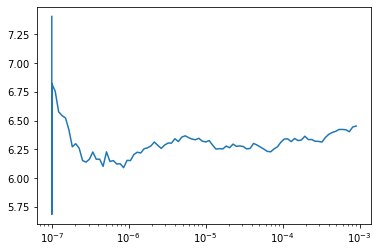

In [20]:
plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log')
plt.show()

## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
model = InpaintingUnet(vgg_weights='./data/logs/pytorch_vgg16.h5')
model.load(
    r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase1\weights.23-1.18.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
    epochs=50,  
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/imagenet_phase2',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/imagenet_phase2/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

## Phase 3 - Generating samples
Let us use the fine-tuned network to get some sample. We will save results in `data/test_samples` folder

In [4]:
model = InpaintingUnet(
    conv_layer='gconv', 
    load_weights='./data/logs/imagenet_phase1_gconv/weights.47-24.02'
)

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

In [5]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

  0%|          | 12/12493 [00:46<13:34:26,  3.92s/it]
